In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns; sns.set()
import pandas as pd
import os, time, re
import time
#import tensorflow

from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline,Pipeline

In [2]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    CS = ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    labels = ['margins','decision boundary']
    for i in range(len(labels)):
        CS.collections[i].set_label(labels[i])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=100, linewidths=0.8, edgecolors = "black",
                   facecolors = "none", label = 'support vectors');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    plt.legend(loc='upper left')
    
def plot_decision_regions(X, y, classifier, test_idx=None,  
                          resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap, label = 'o')

    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        l = "class " + str(cl)
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=l, 
                    edgecolor='black')
    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]   
        
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='test set') 
            
    plt.legend(loc='upper left')

## Experiment 1

In [3]:
#Data downloaded from https://sci2s.ugr.es/keel/dataset/data/classification/banana.zip at 21/08 11:34h
current_path = os.getcwd()
banana_file = '\\datasets\\banana.dat'
df = pd.DataFrame()
df = pd.read_csv(current_path + banana_file,comment = '@',header=None)

In [4]:
#Getting the numpy arrays and split the training and test set.
X = df.loc[:, :1].values
y = df.loc[:, 2].values
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y,random_state=1)

Number of points in class 1.0: 2376
Number of points in class -1.0: 2924
Max-min of values in X[:,0]: -3.09 ~ 2.81
Max-min of values in X[:,1]: -2.39 ~ 3.19


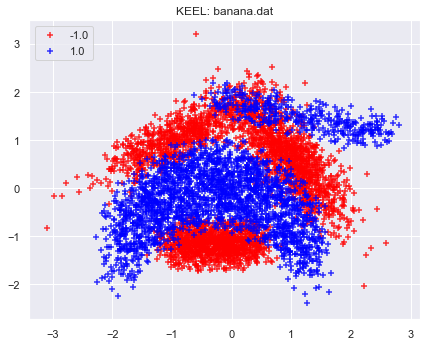

In [5]:
# Number of examples in each class in the whole set
plt.rcParams['figure.figsize'] = [7,5.5]
print("Number of points in class 1.0:", len(y[y[:]==1.0]))
print("Number of points in class -1.0:",len(y[y[:]==-1.0]))
print("Max-min of values in X[:,0]:", np.min(X[:,0]),"~", np.max(X[:,0]))
print("Max-min of values in X[:,1]:", np.min(X[:,1]),"~", np.max(X[:,1]))

#Plot using the scatter plot
cmap = ["red", "blue"]
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],alpha=0.8, c=cmap[idx], marker="+", label=cl)
    
plt.legend(loc='upper left')
plt.title("KEEL: banana.dat")
plt.show()

In [6]:
#Set of parameters for each SVM test 
param_grid = [{'svc__kernel': 'sigmoid','svc__gamma': 1},
              {'svc__kernel': 'sigmoid','svc__gamma': 0.5},
              {'svc__kernel': 'sigmoid','svc__gamma': 0.01},
              {'svc__kernel': 'linear','svc__C': 1},
              {'svc__kernel': 'linear','svc__C': 0.1},
              {'svc__kernel': 'linear','svc__C': 10},
              {'svc__kernel': 'poly','svc__C': 1},
              {'svc__kernel': 'poly','svc__C': 0.1},
              {'svc__kernel': 'poly','svc__C': 10},
              {'svc__kernel': 'rbf','svc__C': 1},
              {'svc__kernel': 'rbf','svc__C': 0.1},
              {'svc__kernel': 'rbf','svc__C': 10},
             ]

#DataFrame to store model results
models = pd.DataFrame(columns = ['kernel','cv = 2','cv = 5', 'cv = 10','Eout'])
ps = []
for param in param_grid:    
    
    #make_pipeline makes it easy to apply the serial transformations.
    if 'svc__gamma' in param:
        print (param['svc__kernel'],param['svc__gamma'])
        p = make_pipeline(StandardScaler(),
            SVC(kernel = param['svc__kernel'], gamma = param['svc__gamma']))
        k = str(param['svc__kernel']) + ", gamma: "+ str(param['svc__gamma'])
    else: 
        print (param['svc__kernel'],param['svc__C'])
        p = make_pipeline(StandardScaler(),
            SVC(kernel = param['svc__kernel'], C = param['svc__C']))
        k = str(param['svc__kernel']) +", C: " + str(param['svc__C'])  
        
    p.fit(X_train,y_train)
    Eout = p.score(X_test,y_test) 
    ps.append(p)
    
    #Calculating cross-validation scores
    scores = [];
    for idx,cv in enumerate([2,5,10]):
        scores.append(cross_val_score(estimator=p,X=X_train,y=y_train,cv=cv,n_jobs=1))
     
    #Building basic result's table 
    models = models.append({'kernel':k,
                            'cv = 2':np.mean(scores[0]),
                            'cv = 5':np.mean(scores[1]),
                            'cv = 10':np.mean(scores[2]),
                            'Eout':Eout},ignore_index=True)

models

sigmoid 1
sigmoid 0.5
sigmoid 0.01
linear 1
linear 0.1
linear 10
poly 1
poly 0.1
poly 10
rbf 1
rbf 0.1
rbf 10


,kernel,cv = 2,cv = 5,cv = 10,Eout
0,"sigmoid, gamma: 1",0.292218,0.289855,0.290327,0.269811
1,"sigmoid, gamma: 0.5",0.300941,0.297404,0.298817,0.286792
2,"sigmoid, gamma: 0.01",0.551651,0.551651,0.551651,0.551887
3,"linear, C: 1",0.551651,0.551651,0.551651,0.551887
4,"linear, C: 0.1",0.551651,0.551651,0.551651,0.551887
5,"linear, C: 10",0.551651,0.551651,0.551651,0.551887
6,"poly, C: 1",0.632544,0.636091,0.634441,0.641509
7,"poly, C: 0.1",0.631603,0.634677,0.634914,0.640566
8,"poly, C: 10",0.633016,0.636798,0.634912,0.642453
9,"rbf, C: 1",0.896463,0.898115,0.898587,0.918868


In [9]:
print (models.to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
               kernel &    cv = 2 &    cv = 5 &   cv = 10 &      Eout \\
\midrule
    sigmoid, gamma: 1 &  0.292218 &  0.289855 &  0.290327 &  0.269811 \\
  sigmoid, gamma: 0.5 &  0.300941 &  0.297404 &  0.298817 &  0.286792 \\
 sigmoid, gamma: 0.01 &  0.551651 &  0.551651 &  0.551651 &  0.551887 \\
         linear, C: 1 &  0.551651 &  0.551651 &  0.551651 &  0.551887 \\
       linear, C: 0.1 &  0.551651 &  0.551651 &  0.551651 &  0.551887 \\
        linear, C: 10 &  0.551651 &  0.551651 &  0.551651 &  0.551887 \\
           poly, C: 1 &  0.632544 &  0.636091 &  0.634441 &  0.641509 \\
         poly, C: 0.1 &  0.631603 &  0.634677 &  0.634914 &  0.640566 \\
          poly, C: 10 &  0.633016 &  0.636798 &  0.634912 &  0.642453 \\
            rbf, C: 1 &  0.896463 &  0.898115 &  0.898587 &  0.918868 \\
          rbf, C: 0.1 &  0.884437 &  0.887505 &  0.888451 &  0.919811 \\
           rbf, C: 10 &  0.900942 &  0.900711 &  0.900951 &  0.920755 \\
\bottomrul

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
(4240, 2) (4240,)


C:\Users\gabri\AppData\Local\conda\conda\envs\unsupervisedLearning\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)


Text(0.5, 1.0, 'KEEL: Banana.dat, worst SVM found')

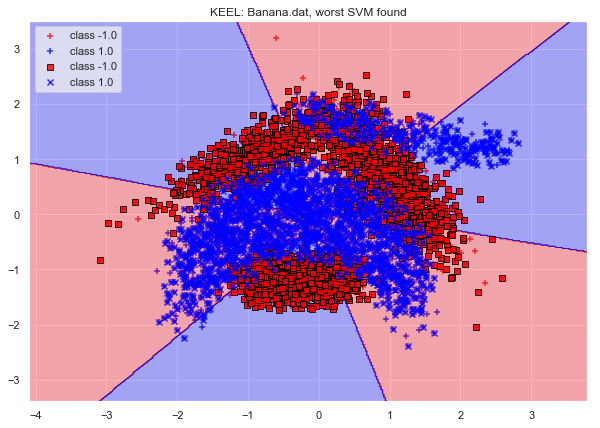

In [10]:
plt.rcParams['figure.figsize'] = [10,7]
c = StandardScaler()

# Here we put the worst parameters.
p = SVC(kernel = 'sigmoid', gamma = 1)
p.fit(c.fit_transform(X_train),y_train)
clf = p
    
for idx, cl in enumerate(np.unique(y)):
    l = "class " + str(cl)
    plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],alpha=0.8, c=cmap[idx], marker="+", label=l )
    
print (clf)    
print (c.fit_transform(X_train).shape,y_train.shape)
plot_decision_regions(X_train,y_train,classifier = clf)

#Plotting the support vector is uninformative
#plot_svc_decision_function(clf,plot_support = True)
plt.title("KEEL: Banana.dat, worst SVM found")

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
(4240, 2) (4240,)


Text(0.5, 1.0, 'KEEL: Banana.dat, best SVM found')

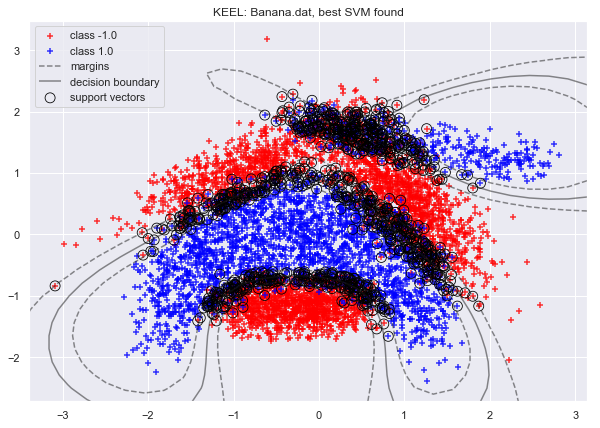

In [11]:
plt.rcParams['figure.figsize'] = [10,7]
c = StandardScaler()

# Here we put the best parameters and generate the corresponding classifier again
p = SVC(kernel = 'rbf', C = 10)
p.fit(c.fit_transform(X_train),y_train)
clf = p
    
for idx, cl in enumerate(np.unique(y)):
    l = "class " + str(cl)
    plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],alpha=0.8, c=cmap[idx], marker="+", label=l )
    
print (clf)
print (c.fit_transform(X_train).shape,y_train.shape)

plot_svc_decision_function(clf,plot_support = True)
plt.title("KEEL: Banana.dat, best SVM found")

Random Forest accuracy is : 0.9


C:\Users\gabri\AppData\Local\conda\conda\envs\unsupervisedLearning\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)
C:\Users\gabri\AppData\Local\conda\conda\envs\unsupervisedLearning\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)


Text(0.5, 1.0, 'KEEL: Banana.dat, using RandomForest, showing only 50 points')

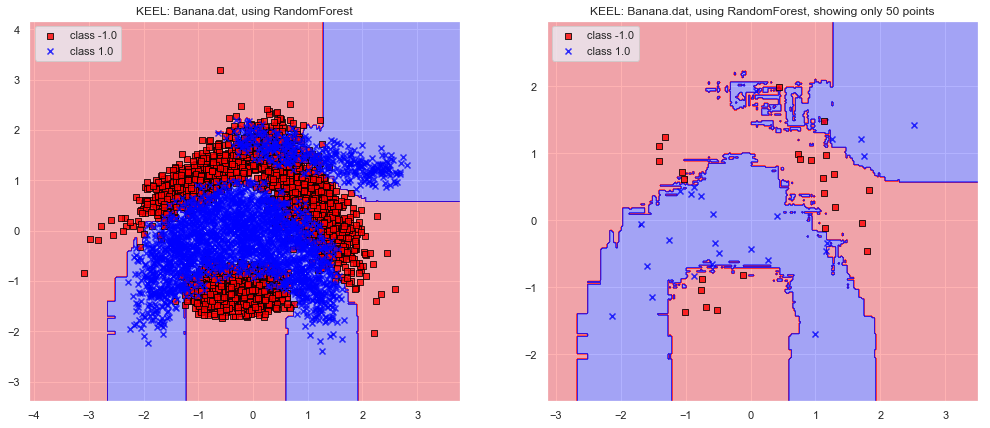

In [12]:
#The other algorithm chosen is random forest
forest = RandomForestClassifier(criterion='gini',
                                 n_estimators=25,
                                 random_state=1,
                                 n_jobs=2)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y,random_state=1)
forest.fit(X_train, y_train)
print ("Random Forest accuracy is :", forest.score(X_test,y_test))

plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
plot_decision_regions(X, y, classifier=forest)
plt.title("KEEL: Banana.dat, using RandomForest")

plt.subplot(1,2,2)
plot_decision_regions(X[:50,:], y[:50], classifier=forest)
plt.title("KEEL: Banana.dat, using RandomForest, showing only 50 points")

## Experiment 2

C:\Users\gabri\AppData\Local\conda\conda\envs\unsupervisedLearning\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)


----------


C:\Users\gabri\AppData\Local\conda\conda\envs\unsupervisedLearning\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)


----------


C:\Users\gabri\AppData\Local\conda\conda\envs\unsupervisedLearning\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)


----------


C:\Users\gabri\AppData\Local\conda\conda\envs\unsupervisedLearning\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\gabri\AppData\Local\conda\conda\envs\unsupervisedLearning\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\gabri\AppData\Local\conda\conda\envs\unsupervisedLearning\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\gabri\AppData\Local\conda\conda\envs\unsupervisedLearning\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(

----------


C:\Users\gabri\AppData\Local\conda\conda\envs\unsupervisedLearning\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)


----------


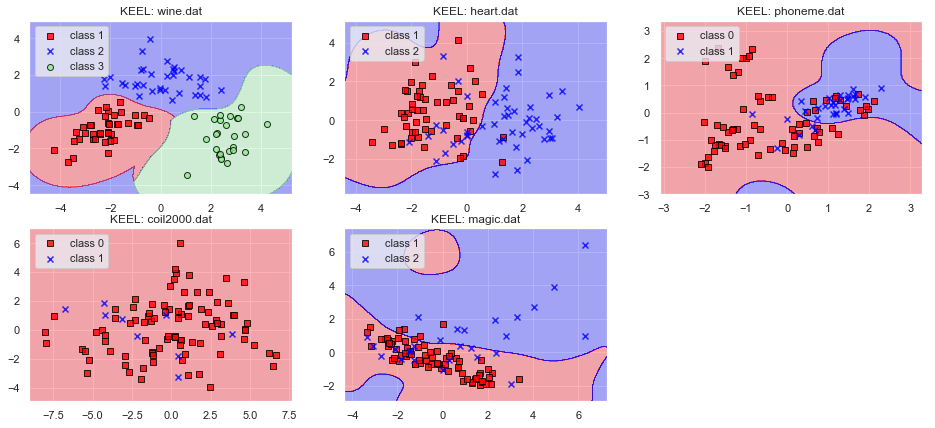

In [13]:
plt.rcParams['figure.figsize'] = [16,7]
models = pd.DataFrame(columns = ['Dataset','Eout'])
best_param = {'kernel': 'rbf', 'C' : 10}
current_path = os.getcwd()
datasets = ['wine','heart','phoneme','coil2000','magic']
cmap = ['red','blue','green','purple']

for idx,i in enumerate(datasets):
    file = '\\datasets\\' + i + '.dat'
    df = pd.read_csv(current_path + file, comment = '@',header = None)
    
    #Pipeline for data fit and prediction
    p = make_pipeline(StandardScaler(),
                      PCA(n_components = 2),
            SVC(kernel = best_param['kernel'], C = best_param['C'],
                gamma = 'auto')) 
        
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y,test_size=0.2,  stratify=y,random_state=np.random.randint(100))   
    
    p.fit(X_train,y_train)
    Eout = p.score(X_test,y_test)
    
    Ebaseline,class_k = 0,[];    
    for a , b in enumerate(np.unique(y_test)):
        class_k.append(len(y_test[y_test[:]==b])/len(y_test[:]))
    
    #Baseline is calculated by classifing equally all point on the test set by the most numerous class.
    Ebaseline = np.max(class_k);
    
    #This new part is for the plotting phase, because we can't divide the previous pipeline for the PCA results.
    s = StandardScaler()
    t = PCA(n_components = 2)
    X_train = t.fit_transform(s.fit_transform(X_train))
    k = SVC(kernel = best_param['kernel'], C = best_param['C'],gamma = 'auto')
    
    #Fixing for specific behaviour for "magic.dat"
    if i == 'magic':                                            
        for idx2, cl2 in enumerate(np.unique(y)):
            for idx3,cl3 in enumerate(y_train):
                if y_train[idx3] == cl2:
                    y_train[idx3] = np.int64(idx2 +1) 
             
        y_train = y_train.astype(int)
        
    k.fit(X_train,y_train)
    
  
    plt.subplot(2, 3, idx + 1)   
    
    #Too many point hide the decision regions   
    if X_train.shape[0]>100:
        plot_decision_regions(X_train[:100,:], y_train[:100], classifier=k)
    else:
        plot_decision_regions(X_train, y_train, classifier=k)

    
    plt.title("KEEL: " + i + ".dat")
    
    #Adding to a Dataset to later transform to the results table.
    models = models.append({'Dataset': i,
                            'Eout':Eout,
                            'Ebaseline': Ebaseline},ignore_index=True)
    print ("-"*10)
plt.show()   

In [14]:
print (models.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
  Dataset &      Eout &  Ebaseline \\
\midrule
     wine &  0.972222 &   0.388889 \\
    heart &  0.814815 &   0.555556 \\
  phoneme &  0.806660 &   0.706753 \\
 coil2000 &  0.940458 &   0.940458 \\
    magic &  0.752103 &   0.648265 \\
\bottomrule
\end{tabular}



## Experiment 3

In [1]:
from keras import layers
from keras import models
from keras.datasets import mnist
from keras.utils import to_categorical

Using TensorFlow backend.
C:\Users\gabri\AppData\Local\conda\conda\envs\unsupervisedLearning\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\gabri\AppData\Local\conda\conda\envs\unsupervisedLearning\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\gabri\AppData\Local\conda\conda\envs\unsupervisedLearning\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

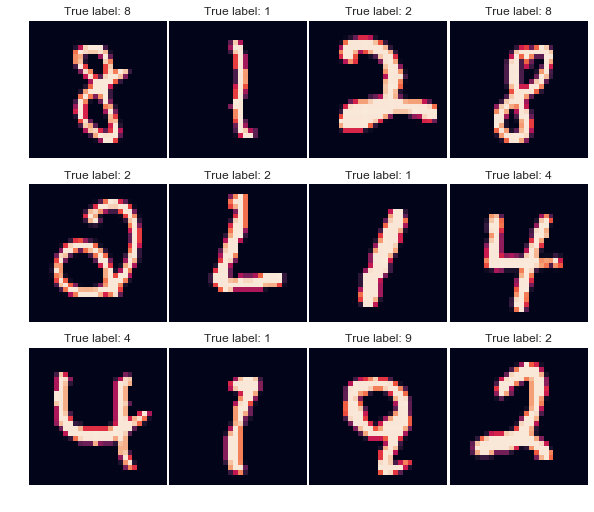

In [4]:
#Cheking some data instances and generate the paper's image.
portion = np.random.randint(0, train_images.shape[0],12)

sample_digits = train_images[portion]
sample_labels = train_labels[portion]

rows = 3
columns = 4
f, ax = plt.subplots(rows, columns, figsize=(10,9),gridspec_kw={'wspace':0.02, 'hspace':0.01},squeeze=True)

for r in range(rows):
    for c in range(columns):
        i = 4*r + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_digits[i])
        ax[r,c].set_title('True label: %d' % sample_labels[i])

In [5]:
#Convolutional neural network with the dense last layers which is a common approach in deep learning,
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#Separatng training and validation data
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

sec = int(0.1 * len(train_images))
val_data = train_images[:sec,:]
val_labels = train_labels[:sec,:]

train_images2 = train_images[sec:,:]
train_labels2 = train_labels[sec:,:]

#Compile the model with the following parameters
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Fit for 20 epoches to study generalization behaviour
history = model.fit(train_images2, train_labels2, validation_data=(val_data, val_labels) , epochs=20, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 48s 885us/step - loss: 0.1880 - acc: 0.9414 - val_loss: 0.0550 - val_acc: 0.9843
Epoch 2/20
54000/54000 [==============================] - 61s 1ms/step - loss: 0.0504 - acc: 0.9840 - val_loss: 0.0561 - val_acc: 0.9825
Epoch 3/20
54000/54000 [==============================] - 61s 1ms/step - loss: 0.0349 - acc: 0.9889 - val_loss: 0.0511 - val_acc: 0.9845
Epoch 4/20
54000/54000 [==============================] - 38s 712us/step - loss: 0.0255 - acc: 0.9917 - val_loss: 0.0410 - val_acc: 0.9883
Epoch 5/20
54000/54000 [==============================] - 40s 744us/step - loss: 0.0195 - acc: 0.9940 - val_loss: 0.0413 - val_acc: 0.9897
Epoch 6/20
54000/54000 [==============================] - 42s 787us/step - loss: 0.0171 - acc: 0.9945 - val_loss: 0.0377 - val_acc: 0.9917
Epoch 7/20
54000/54000 [==============================] - 44s 816us/step 

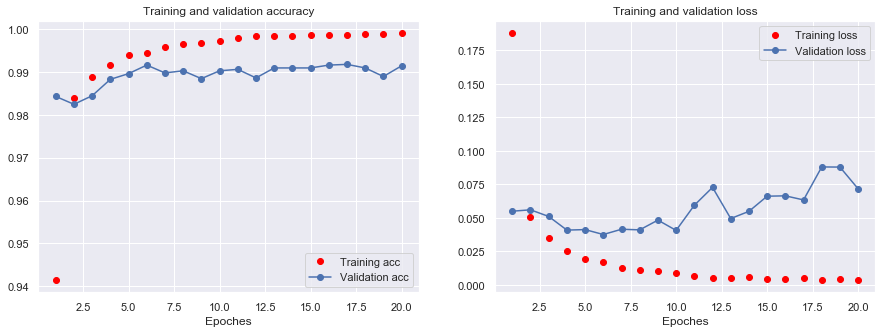

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc', color = "red")
plt.plot(epochs, val_acc, 'b', marker = "o", label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoches')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss' , color = "red")
plt.plot(epochs, val_loss, 'b', marker = "o", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoches')
plt.legend()
plt.show()

In [8]:
#Making the choice for 7 epoches.

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#Separatng training and validation data
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

sec = int(0.1 * len(train_images))
val_data = train_images[:sec,:]
val_labels = train_labels[:sec,:]

train_images2 = train_images[sec:,:]
train_labels2 = train_labels[sec:,:]

#Compile the model with the following parameters
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_images2, train_labels2, validation_data=(val_data, val_labels) , epochs=7, batch_size=64)

Train on 54000 samples, validate on 6000 samples
Epoch 1/7
54000/54000 [==============================] - 42s 780us/step - loss: 0.1785 - acc: 0.9446 - val_loss: 0.0678 - val_acc: 0.9777
Epoch 2/7
54000/54000 [==============================] - 48s 887us/step - loss: 0.0500 - acc: 0.9846 - val_loss: 0.0419 - val_acc: 0.9890
Epoch 3/7
54000/54000 [==============================] - 51s 944us/step - loss: 0.0329 - acc: 0.9900 - val_loss: 0.0582 - val_acc: 0.9820
Epoch 4/7
54000/54000 [==============================] - 51s 953us/step - loss: 0.0250 - acc: 0.9926 - val_loss: 0.0347 - val_acc: 0.9887
Epoch 5/7
54000/54000 [==============================] - 50s 925us/step - loss: 0.0194 - acc: 0.9940 - val_loss: 0.0395 - val_acc: 0.9902
Epoch 6/7
54000/54000 [==============================] - 47s 864us/step - loss: 0.0159 - acc: 0.9949 - val_loss: 0.0328 - val_acc: 0.9903
Epoch 7/7
54000/54000 [==============================] - 42s 782us/step - loss: 0.0126 - acc: 0.9962 - val_loss: 0.0431 - v

In [9]:
test_loss, test_accuracy = \
  model.evaluate(test_images, test_labels, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

10000/10000 [==============================] - 2s 202us/step
Test loss: 0.0299 accuracy: 0.9916
